# NN back propagation(神经网络反向传播)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import matplotlib
import scipy.optimize as opt
from sklearn.metrics import classification_report#这个包是评价报告

In [3]:
def load_data(path, transpose=True):
    data = sio.loadmat(path)
    y = data.get('y') #(5000,1)
    y = y.reshape(y.shape[0])#make it back to column vector
    
    X = data.get('X') #(5000,400)
    
    if transpose:
        #for this dataset, you need a transpose to get the orientation right
        X = np.array([im.reshape((20,20)).T for im in X])
        
        # and I flat the image again to preserve the vector presentation
        X = np.array([im.reshape(400) for im in X])
        
    return X,y 

In [4]:
X, _ = load_data('ex4data1.mat')

In [7]:
def plot_100_image(X):
    size = int(np.sqrt(X.shape[1]))
    
    sample_idx = np.random.choice(np.arange(X.shape[0]), 100)
    sample_images = X[sample_idx, :]
    
    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(8,8))
    
    for r in range(10):
        for c in range(10):
            ax_array[r, c].matshow(sample_images[10 * r + c].reshape((size, size)),
                                   cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))

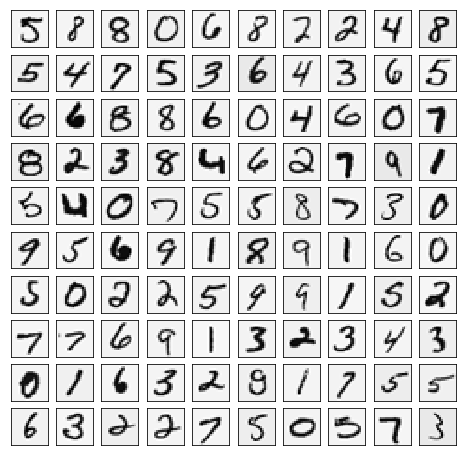

In [8]:
plot_100_image(X)
plt.show()

# 代价函数

In [9]:
X_raw, y_raw = load_data('ex4data1.mat', transpose=False)
X = np.insert(X_raw, 0, np.ones(X_raw.shape[0]),axis=1) #增加全部为1的一列
X.shape

(5000, 401)

In [10]:
y_raw

array([10, 10, 10, ...,  9,  9,  9], dtype=uint8)

In [11]:
def expand_y(y):
    # expand 5000*1 into 5000*10
    # where y=10->[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]: ndarray
    res = []
    for i in y:
        y_array = np.zeros(10)
        y_array[i - 1] = 1
        
        res.append(y_array)
    
    return np.array(res)


In [13]:
y = expand_y(y_raw)
y  

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

# 读取权重

In [14]:
def load_weight(path):
    data = sio.loadmat(path)
    return data['Theta1'], data['Theta2']


In [15]:
t1, t2 = load_weight('ex4weights.mat')
t1.shape, t2.shape

((25, 401), (10, 26))

In [16]:
def serialize(a, b):
    return np.concatenate((np.ravel(a), np.ravel(b)))
# 序列化2矩阵
# 在这个nn架构中，我们有theta1（25,401），theta2（10,26），它们的梯度是delta1，delta2 

In [17]:
theta = serialize(t1, t2) # 扁平化参数，25*401+10*26=10285
theta.shape

(10285,)

# feed forward(前向传播)

(400 + 1) -> (25 + 1) -> (10)

In [19]:
def feed_forward(theta, X):
    '''
    apply to architecture (400 + 1) * (25+1) * 10
    X: 5000 * 401
    '''
    t1, t2 = deserialize(theta) #t1:(25,401), t2:(10,26)
    m = X.shape[0]
    a1 = X # 5000 * 401
    
    z2 = a1 @ t1.T # 5000 * 25
    # 加了一个sigmoid
    a2 = np.insert(sigmoid(z2), 0, np.ones(m), axis=1) # 5000*26
    z3 = a2 @ t2.T #5000 * 10
    h = sigmoid(z3)
    
    return a1, z2, a2, z3, h # you need all those for backpropagation

In [20]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [25]:
def deserialize(seq):
#     """into ndarray of (25, 401), (10, 26)"""
    return seq[:25 * 401].reshape(25, 401), seq[25 * 401:].reshape(10, 26)

In [26]:
_, _, _, _, h = feed_forward(theta ,X)
h #5000*10

array([[1.12661530e-04, 1.74127856e-03, 2.52696959e-03, ...,
        4.01468105e-04, 6.48072305e-03, 9.95734012e-01],
       [4.79026796e-04, 2.41495958e-03, 3.44755685e-03, ...,
        2.39107046e-03, 1.97025086e-03, 9.95696931e-01],
       [8.85702310e-05, 3.24266731e-03, 2.55419797e-02, ...,
        6.22892325e-02, 5.49803551e-03, 9.28008397e-01],
       ...,
       [5.17641791e-02, 3.81715020e-03, 2.96297510e-02, ...,
        2.15667361e-03, 6.49826950e-01, 2.42384687e-05],
       [8.30631310e-04, 6.22003774e-04, 3.14518512e-04, ...,
        1.19366192e-02, 9.71410499e-01, 2.06173648e-04],
       [4.81465717e-05, 4.58821829e-04, 2.15146201e-05, ...,
        5.73434571e-03, 6.96288990e-01, 8.18576980e-02]])

# 代价函数

In [29]:
def cost(theta, X, y):
    '''
    calculate cost
    y:(m,k) ndarray
    '''
    m = X.shape[0] # get the data size m
    
    _, _, _, _, h = feed_forward(theta ,X)
    
    # np.multiply is pairwise operation
    pair_computation = -np.multiply(y, np.log(h)) - np.multiply((1-y), np.log(1-h))
    
    return pair_computation.sum() / m

In [30]:
cost(theta, X, y)

0.2876291651613189

# 正则化代价函数

the first column of t1 and t2 is intercept θ, just forget them when you do regularization

In [39]:
def regularized_cost(theta, X, y, l=1):
    """the first column of t1 and t2 is intercept theta, ignore them when you do regularization"""
    t1, t2 = deserialize(theta)  # t1: (25,401) t2: (10,26)
    m = X.shape[0]

    reg_t1 = (l / (2 * m)) * np.power(t1[:, 1:], 2).sum()  # this is how you ignore first col
    reg_t2 = (l / (2 * m)) * np.power(t2[:, 1:], 2).sum()

    return cost(theta, X, y) + reg_t1 + reg_t2

In [40]:
regularized_cost(theta, X, y)

0.38376985909092365

# 反向传播

读取数据和权重过程与前向传播相同

In [42]:
X.shape, y.shape

((5000, 401), (5000, 10))

In [43]:
t1.shape, t2.shape

((25, 401), (10, 26))

In [45]:
theta.shape

(10285,)

In [48]:
def sigmoid_gradient(z):
    """
    pairwise op is key for this to work on both vector and matrix
    """
    return np.multiply(sigmoid(z), 1 - sigmoid(z))


In [49]:
sigmoid_gradient(0)

0.25

# theta gradient

super hard to get this right... the dimension is so confusing

In [55]:
def gradient(theta, X, y):
    # initialize
    t1, t2 = deserialize(theta)  # t1: (25,401) t2: (10,26)
    m = X.shape[0]

    delta1 = np.zeros(t1.shape)  # (25, 401)
    delta2 = np.zeros(t2.shape)  # (10, 26)

    a1, z2, a2, z3, h = feed_forward(theta, X)

    for i in range(m):
        a1i = a1[i, :]  # (1, 401)
        z2i = z2[i, :]  # (1, 25)
        a2i = a2[i, :]  # (1, 26)

        hi = h[i, :]    # (1, 10)
        yi = y[i, :]    # (1, 10)

        d3i = hi - yi  # (1, 10)

        z2i = np.insert(z2i, 0, np.ones(1))  # make it (1, 26) to compute d2i
        d2i = np.multiply(t2.T @ d3i, sigmoid_gradient(z2i))  # (1, 26)

        # careful with np vector transpose
        delta2 += np.matrix(d3i).T @ np.matrix(a2i)  # (1, 10).T @ (1, 26) -> (10, 26)
        delta1 += np.matrix(d2i[1:]).T @ np.matrix(a1i)  # (1, 25).T @ (1, 401) -> (25, 401)

    delta1 = delta1 / m
    delta2 = delta2 / m

    return serialize(delta1, delta2)

In [56]:
d1, d2 = deserialize(gradient(theta, X, y))

In [57]:
d1.shape, d2.shape

((25, 401), (10, 26))